# Blood cells


# Tasks

To pass you need to turn in a runable notebook  (ipynb) and a pdf version of that notebook. Start the filename and your title with your group number, which assignment, then your names. E.g. 42_3a_EbbaBergman_AkshaiFILLIN_DavidFILLIN_JonathanFILLIN.ipynb

Note: Previously we've run with 5-10 epochs, I'd reccomend starting with atleast 30 epochs in this assignment, if it takes a long time to run contact a teacher

Complete the following tasks

1. Motivate why you are using the architecture you are using and hand in  
    a) One network not using the masks provided  
    b) One network using the masks provided  
    c) compare the two and discuss the impact the masks did or did not have (1 paragraph)  

2. Improve your network  
    a) Choose a network that you think is better to proceed with, motivate why
    b) Try 3 different improvements of your network, motivate your choices
    c) Combine your 3 improvements, discuss the results

3. A badly performing network run atleast once. Motivate why you chose this network (1 paragraph). 

The first, good neural network is the focus of this assignment.   

For the bad network I wouldn't recommend spending more than 30 minutes on this unless you really, really want. I do not think everyone will need 30 minutes.  

4. Evaluate your best network using  your test set and atleast 3 metrics and discuss their differences/similarities in relation to your results.  (1-3 paragraphs)
Hint: https://www.tensorflow.org/api_docs/python/tf/keras/metrics might be useful to look at for your fit method


# Data info

Xinyi Dai wrote her master thesis in 2022, and you can find it here: https://uu.diva-portal.org/smash/get/diva2:1681915/FULLTEXT01.pdf

You are not going to do the exact same thing that she did, and you are not allowed to use her code or her exact techniques and architectures.

It might be interesting for you to look at the flow of data below, here we will only focus on the Deep Learning part, but as you can see there are several steps between the first images from the microscope and the application of them.

Note that in this dataset I have removed the controll class for easier modelling

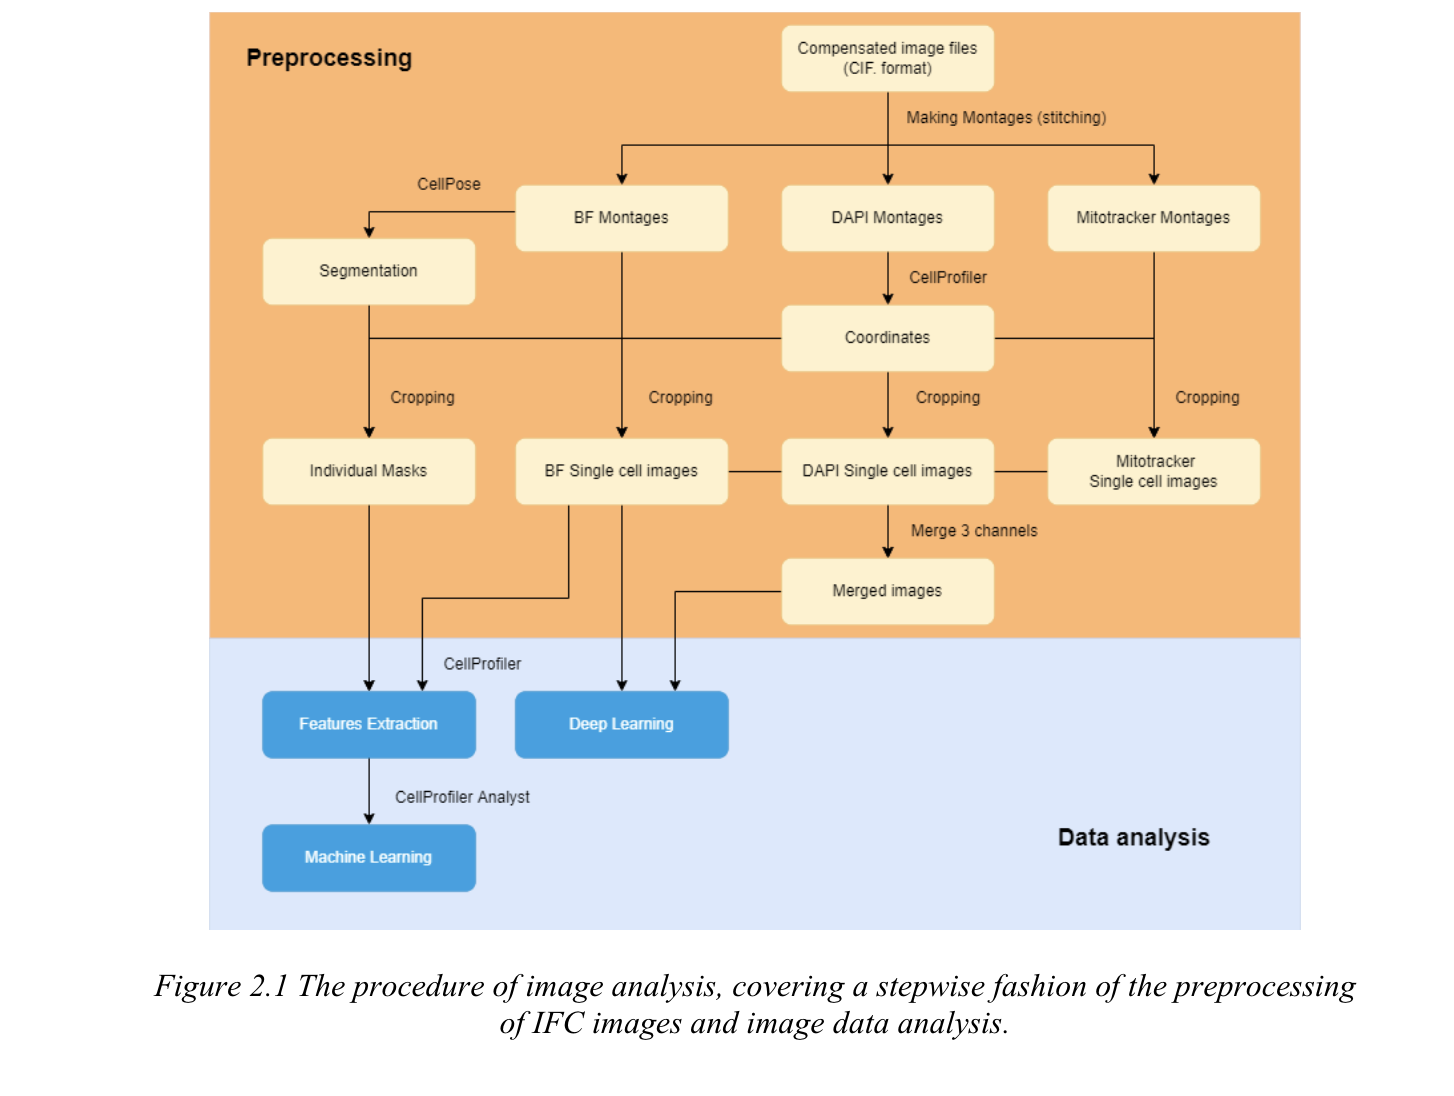

# Imports

In [150]:
import numpy as np
import tensorflow as tf
import pandas as pd
import IPython
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from datetime import datetime
import cv2
import os 

from IPython.display import display, HTML

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io, img_as_uint
import matplotlib.pyplot as plt

In [151]:
from importlib.machinery import SourceFileLoader
base_path = '/home/jovyan/big-data_deeplearning/'


cnn_helper = SourceFileLoader("cnn_helper", base_path + "Labs/"+"cnn_helper.py").load_module()
plot_helper = SourceFileLoader("plot_helper", base_path + "Labs/" +"plot_helper.py").load_module()

In [152]:
# Configure GPUs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      print("Done setting memory_growth")
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except Exception as e:
    # Memory growth must be set before GPUs have been initialized
    print("If you get this , probably done already")
    # Catch the exception and display a custom HTML message with red text
    message = """There was some problems setting up the GPU,
                 it is probably best to restart kernel and clear
                 all outputs before starting over
              """
    display(HTML(f"<div style='color: red;'><strong>Warning:</strong>{message}</div>"))
    print(e)

Num GPUs Available:  1
Done setting memory_growth
1 Physical GPUs, 1 Logical GPUs


# Paths

In [59]:
lab_data_path = base_path + "re_assignments/LeukemiaCells/"
images_path = lab_data_path + "cell_images/"  # 16bit bf images
masks_path = lab_data_path + "masks/" # masks filted based on csv from cp/cpa

cell_labels_path = images_path +"cell_labels.csv"
mask_labels_path= masks_path + "mask_labels.csv"


# Unpack the data for the leukemia cells just as you did in the labs 

No need to show the code or commands you do for this

# Load Data

In [60]:
df_cell_labels = pd.read_csv(cell_labels_path)
df_mask_labels = pd.read_csv(mask_labels_path)

## Look at a sample of the images

Let's look at the images - always a good start to the project.\
Here random images will be displayed, run this several time to see different images

The plotting functions are in plot_helper.py in this directory if you want to look at them.

In [61]:
df_cell_labels.head()

,filename,type,class,unknown1,unknown2,unknown3,original_image_name
0,cell_bc_s1_1__23.tif,cell,bc,s1,1,NaN,23.tif
1,cell_bc_s1_1__70.tif,cell,bc,s1,1,NaN,70.tif
2,cell_bc_s1_1__195.tif,cell,bc,s1,1,NaN,195.tif
3,cell_bc_s1_1__292.tif,cell,bc,s1,1,NaN,292.tif
4,cell_bc_s1_1__314.tif,cell,bc,s1,1,NaN,314.tif


In [62]:
df_mask_labels.head(2)

,filename,type,class,unknown1,unknown2,original_image_name
0,mask_bc_s1_1_7.tif,mask,bc,s1,1,7.tif
1,mask_bc_s1_1_24.tif,mask,bc,s1,1,24.tif


['bc' 'f' 'fd' 'tent']


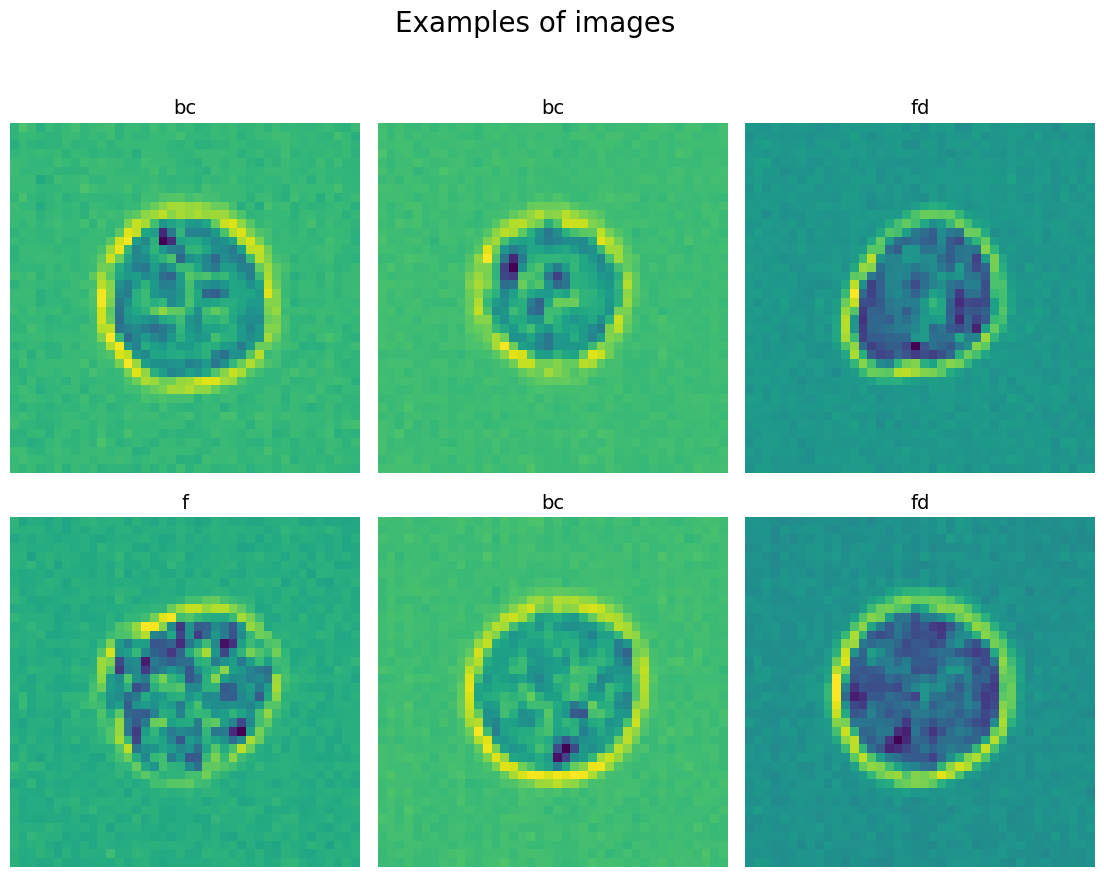

In [63]:
file_column = "filename" ## Enter the name of the file names column
class_column = "class"
print(df_cell_labels[class_column].unique())
plot_helper.show_random_images(images_path, df_cell_labels, file_column, class_column)

['bc' 'fd' 'f' 'tent']
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0


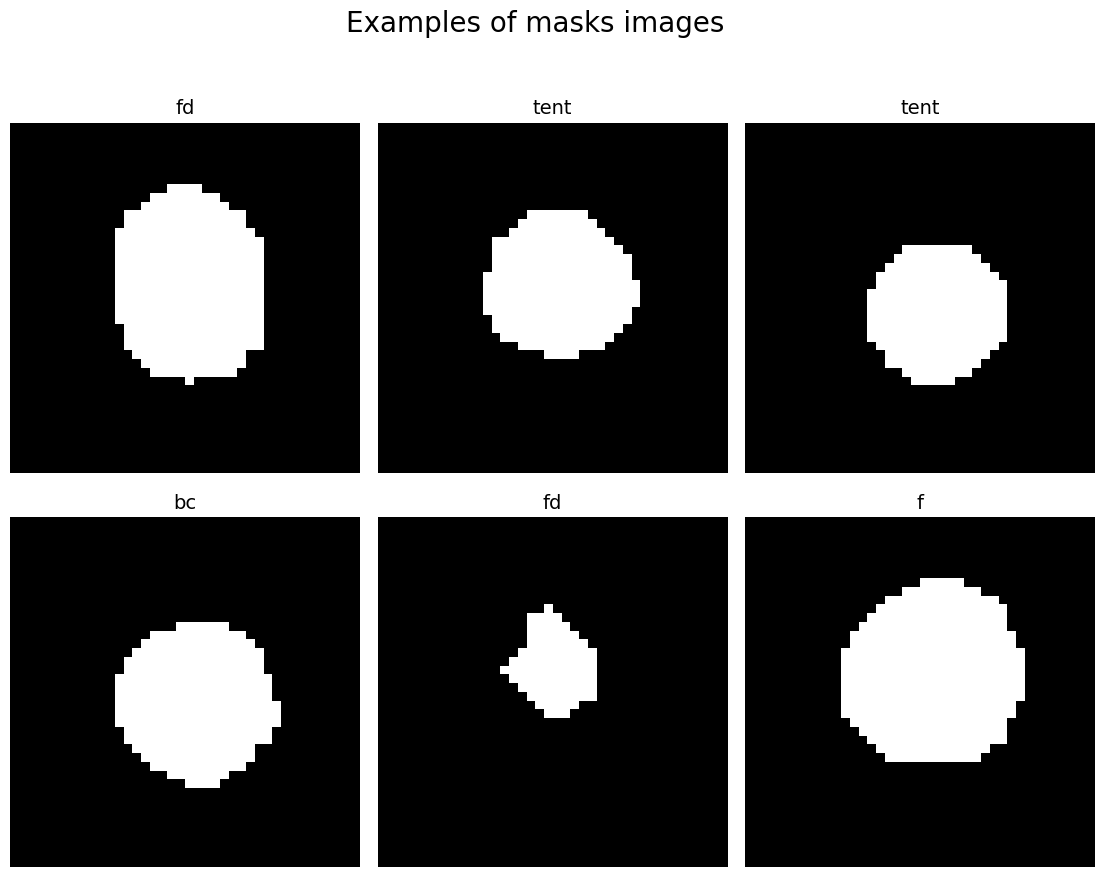

In [64]:
# Code straight from XinYis notebooks, slightly modified by Ebba, probably based on Ebba Bergman's and Phil Harrison's code
# new code to show images here, because the tif files for the masks aren't as easy to show using our usual function

import numpy as np
from skimage import io
import matplotlib.pyplot as plt

print(df_mask_labels[class_column].unique())

figure, ax = plt.subplots(2, 3, figsize=(14, 10))
figure.suptitle("Examples of masks images", fontsize=20)
axes = ax.ravel()

df_images_to_show = df_mask_labels.sample(6)


for i in range(len(axes)):
    row = df_images_to_show.iloc[[i]]
    random_image = io.imread(masks_path+ row[file_column].values[0])
    imgnp = np.array(random_image)
    print(imgnp.max(), imgnp.min())
    axes[i].set_title(row[class_column].values[0], fontsize=14) 
    axes[i].imshow(random_image, cmap='gray')
    axes[i].set_axis_off()
    
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()
plt.close()

# Code snippets you might find useful

In [65]:
image_shape = (32,32)
input_shape = (32,32,1)

### Code below is from XinYi's masters project
#### multiply the bf images with mask to get rid of the backgtound(change it to all black background but only bf cell)

In [66]:
image_files = [f for f in sorted(os.listdir(images_path)) if f.endswith('.tif')]
imgs = [io.imread(images_path+ str(f)) for f in image_files]

In [67]:
mask_files = [f for f in sorted(os.listdir(masks_path)) if f.endswith('.tif')]
masks = [io.imread(masks_path + str(f)) for f in mask_files]

## From here on you will need to add code

In [ ]:
# From XinYi's masters project, slightly modified by Ebba
output_path = base_path + "re_assignments/masked_cells/"

for i in range(len(image_files)):
    img_name = image_files[i]
    filename = str(img_name).split('.')
    imgnp = np.array(imgs[i]) #imgnp = imgnp/imgnp.max()
    masknp= np.array(masks[i]) # masknp= masknp/masknp.max()
    if imgnp.shape != masknp.shape:
        print("could not merge following file due to shape issues: " + str(filename))
        continue
    masked_np = imgnp*masknp
    masked_np = masked_np/masked_np.max()
    masked_np = img_as_uint(masked_np)

    if not os.path.exists(output_path):
        os.mkdir(output_path)
    if masked_np.max() == 65535:
        outfile = output_path + filename[0] + '.tif'
        io.imsave(outfile, masked_np)

<ipython-input-68-6899bd8e1bf6>:13: RuntimeWarning: invalid value encountered in true_divide
  masked_np = masked_np/masked_np.max()


In [45]:
def start_time():
    print("Starting run at: " + str(datetime.now()))

def end_time():
    print("Run finished at: " + str(datetime.now()))
    
def get_image_data_flat_from_file(data_directory, image_paths):
    file_names = image_paths.values.flatten() # Assumes image_paths come in df[image_path_column_name] structure due to lab
    image_data = np.array([np.array(cv2.imread(data_directory + file_name)) for file_name in file_names])
    flattened_image_data = image_data.reshape(image_data.shape[0], -1)
    return flattened_image_data

In [46]:
folder_path = output_path  # Replace with your directory path
output_csv = base_path + "re_assignments/masked_cell_labels.csv"              # Replace with your desired output CSV file path
column_names = ['filename', 'type', 'class', 'unknown1', 'unknown2', 'unknown3', 'original_image_name']  # Adjust column names as needed

masked_cells_labels = cnn_helper.filenames_to_csv(folder_path, output_csv, column_names)

# Merge the cell images with the masks and save in a new folder

In [47]:
folder_path = output_path  # Replace with your directory path
output_csv = base_path + "re_assignments/masked_cell_labels.csv"              # Replace with your desired output CSV file path
column_names = ['filename', 'type', 'class', 'unknown1', 'unknown2', 'unknown3', 'original_image_name']  # Adjust column names as needed

cnn_helper.filenames_to_csv(folder_path, output_csv, column_names)

'/home/jovyan/big-data_deeplearning/re_assignments/masked_cell_labels.csv'

# Look at the mereged images and labels

In [48]:
df_mask_labels = pd.read_csv(output_csv)
df_mask_labels.head()

,filename,type,class,unknown1,unknown2,unknown3,original_image_name
0,cell_bc_s1_1__195.tif,cell,bc,s1,1,NaN,195.tif
1,cell_bc_s1_1__23.tif,cell,bc,s1,1,NaN,23.tif
2,cell_bc_s1_1__292.tif,cell,bc,s1,1,NaN,292.tif
3,cell_bc_s1_1__314.tif,cell,bc,s1,1,NaN,314.tif
4,cell_bc_s1_1__334.tif,cell,bc,s1,1,NaN,334.tif


['bc' 'f' 'fd' 'tent']


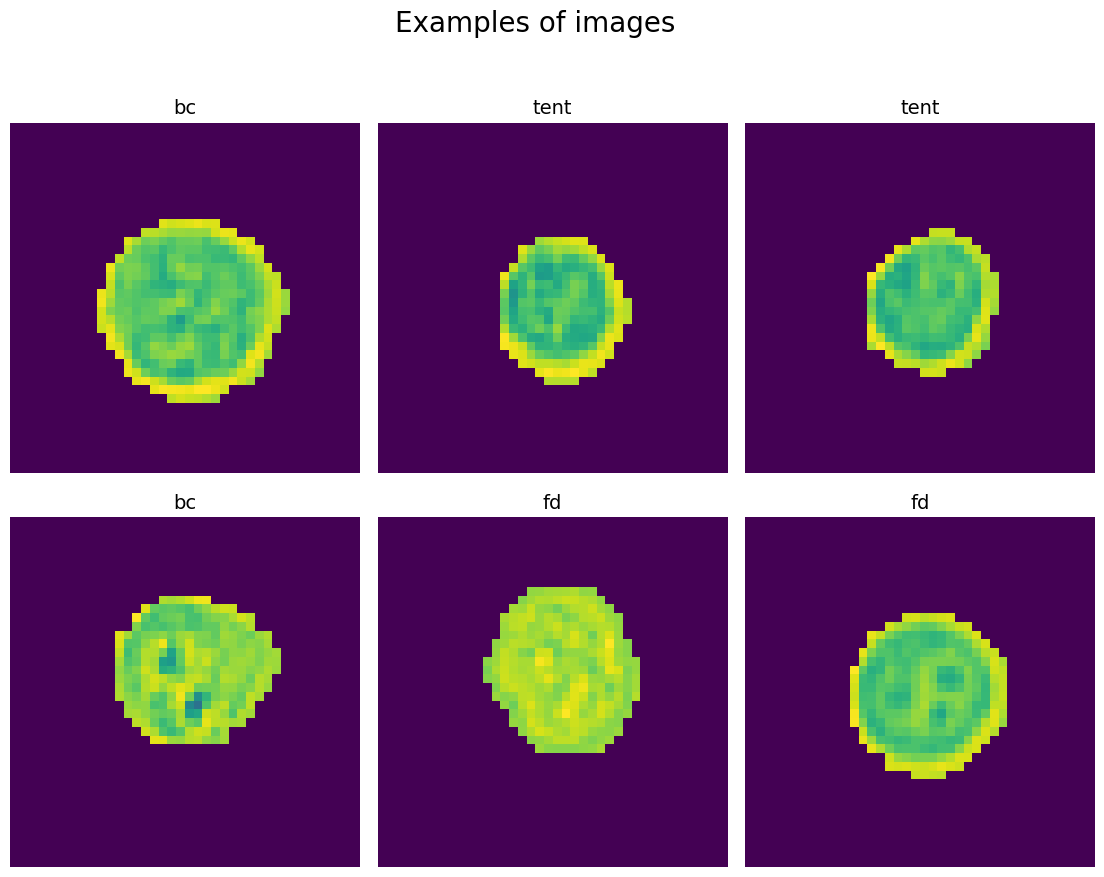

In [49]:
file_column = "filename" ## Enter the name of the file names column
class_column = "class"
print(df_mask_labels[class_column].unique())
plot_helper.show_random_images(folder_path, df_mask_labels, file_column, class_column)

# Part 1

## Make a neural network for the unmasked images and run

In [50]:
df_cell_labels = pd.read_csv(cell_labels_path)
df_cell_labels.head()
df_cell_labels.shape
true_label_column = "class"
df_cell_labels[true_label_column].unique()
df_cell_labels[true_label_column].value_counts()
class_column_header = "class"
df_cell_labels_to_use = df_cell_labels.copy() 
test_set_fraction = 0.1
validation_set_fraction = 0.2
df_cell_test = df_cell_labels_to_use.groupby(class_column_header).sample(frac = test_set_fraction)
df_cell_to_use = pd.concat([df_cell_labels_to_use, df_cell_test, df_cell_test]).drop_duplicates(keep=False) 
df_cell_validation = df_cell_labels_to_use.groupby(class_column_header).sample(frac = validation_set_fraction)
df_cell_train = pd.concat([df_cell_labels_to_use, df_cell_validation, df_cell_validation]).drop_duplicates(keep=False)
print(df_cell_test.head())

                   filename  type class unknown1  unknown2  unknown3  \
3488  cell_bc_s1_1__703.tif  cell    bc       s1         1       NaN   
3651  cell_bc_s1_1__625.tif  cell    bc       s1         1       NaN   
3845  cell_bc_s1_2__407.tif  cell    bc       s1         2       NaN   
2102  cell_bc_s1_2__480.tif  cell    bc       s1         2       NaN   
354   cell_bc_s1_2__487.tif  cell    bc       s1         2       NaN   

     original_image_name  
3488             703.tif  
3651             625.tif  
3845             407.tif  
2102             480.tif  
354              487.tif  


In [81]:
batch_size = 8

image_shape = (40,40)
filename_column = 'filename'
true_label_column = "class"

train_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./65535, samplewise_center=True, samplewise_std_normalization=True)
valid_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./65535, samplewise_center=True, samplewise_std_normalization=True)
test_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./65535, samplewise_center=True, samplewise_std_normalization=True)

train_generator = train_data_generator.flow_from_dataframe(
    df_cell_train, directory=images_path, x_col=filename_column, y_col=true_label_column,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' ,shuffle=True,
)

valid_generator = valid_data_generator.flow_from_dataframe(
    df_cell_validation, directory=images_path, x_col=filename_column, y_col=true_label_column,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' , shuffle=False,
)


test_generator = test_data_generator.flow_from_dataframe(
    df_cell_test, directory=images_path, x_col=filename_column, y_col=true_label_column,
    weight_col=None,class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' , shuffle=False,
)


train_steps = train_generator.n//train_generator.batch_size if train_generator.n >= train_generator.batch_size else 1
validation_steps = valid_generator.n//valid_generator.batch_size if valid_generator.n >= valid_generator.batch_size else 1

Found 4657 validated image filenames belonging to 4 classes.
Found 1163 validated image filenames belonging to 4 classes.
Found 582 validated image filenames belonging to 4 classes.


In [82]:
cnn_inputs = keras.Input(shape=(40, 40, 1))  

x = layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding='same')(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(128, kernel_size=(3, 3), strides=1, padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)

cnn_outputs = layers.Dense(4, activation='softmax')(x)  # Output layer

cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model_unmasked_images")
cnn_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "cnn_Model_unmasked_images"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 40, 40, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 10, 1

In [83]:
epochs = 30
history = cnn_model.fit(x=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )

Epoch 1/30
582/582 [==============================] - 20s 31ms/step - loss: 1.2320 - accuracy: 0.4317 - val_loss: 1.0584 - val_accuracy: 0.5353
Epoch 2/30
582/582 [==============================] - 12s 20ms/step - loss: 1.0213 - accuracy: 0.5692 - val_loss: 1.0304 - val_accuracy: 0.5569
Epoch 3/30
582/582 [==============================] - 12s 20ms/step - loss: 0.8896 - accuracy: 0.6294 - val_loss: 1.0009 - val_accuracy: 0.5793
Epoch 4/30
582/582 [==============================] - 10s 17ms/step - loss: 0.7674 - accuracy: 0.6776 - val_loss: 0.9594 - val_accuracy: 0.6086
Epoch 5/30
582/582 [==============================] - 11s 19ms/step - loss: 0.6574 - accuracy: 0.7285 - val_loss: 0.9561 - val_accuracy: 0.6241
Epoch 6/30
582/582 [==============================] - 12s 20ms/step - loss: 0.5279 - accuracy: 0.7881 - val_loss: 1.1250 - val_accuracy: 0.6017
Epoch 7/30
582/582 [==============================] - 13s 23ms/step - loss: 0.4232 - accuracy: 0.8301 - val_loss: 1.1248 - val_accuracy:

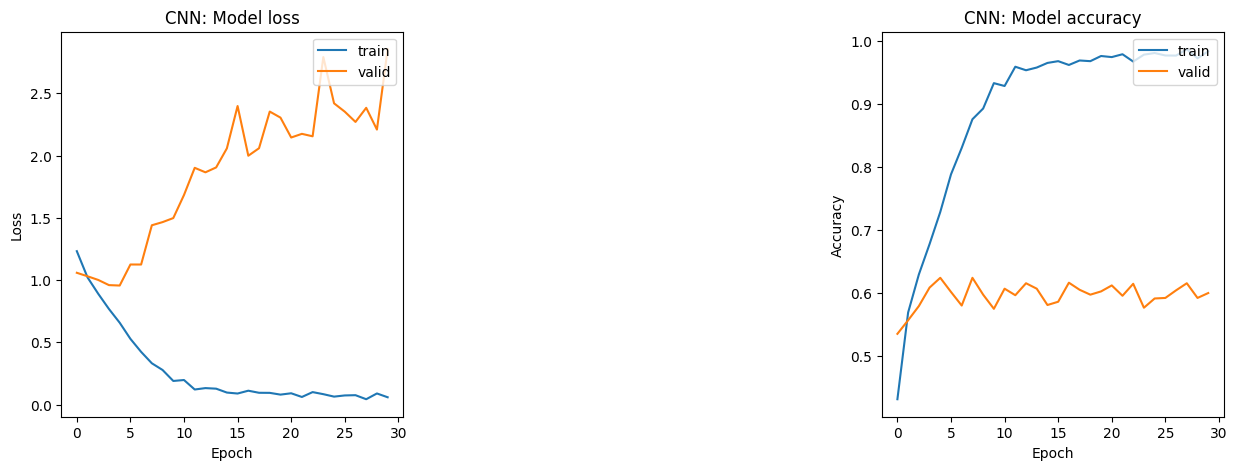

In [84]:
plot_helper.plot_history(history, "CNN")

Accuracy: 0.6010318142734308


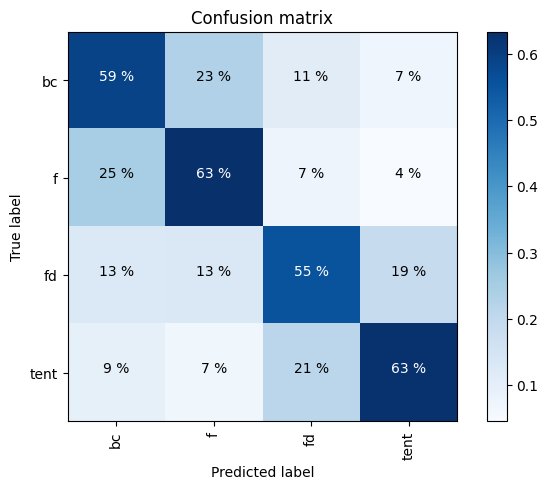

In [85]:
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, valid_generator)

In [86]:
cnn_model.evaluate(test_generator)

73/73 [==============================] - 2s 20ms/step - loss: 0.6880 - accuracy: 0.9072


[0.6879808902740479, 0.907216489315033]

Accuracy: 0.9072164948453608


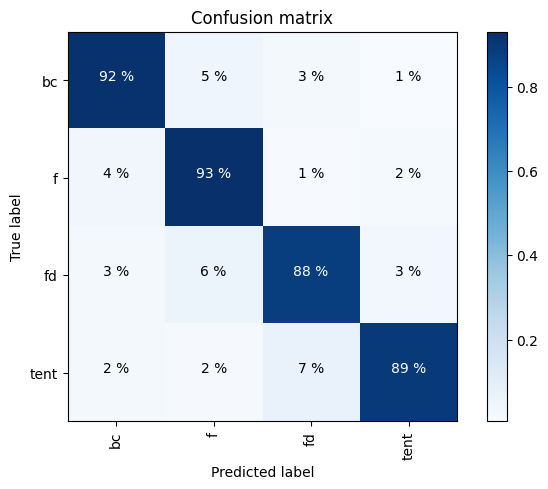

In [87]:
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, test_generator)

## Make a neural network for the masked images and run

In [88]:
df_mask_labels = pd.read_csv('/home/jovyan/big-data_deeplearning/re_assignments/masked_cell_labels.csv')
df_mask_labels.head()
df_mask_labels.shape
true_label_column = "class"
df_mask_labels[true_label_column].unique()
df_mask_labels[true_label_column].value_counts()
class_column_header = "class"
df_mask_labels_to_use = df_mask_labels.copy() 
test_set_fraction = 0.1
validation_set_fraction = 0.2
df_mask_test = df_mask_labels_to_use.groupby(class_column_header).sample(frac = test_set_fraction)
df_mask_to_use = pd.concat([df_mask_labels_to_use, df_mask_test, df_mask_test]).drop_duplicates(keep=False) 
df_mask_validation = df_mask_labels_to_use.groupby(class_column_header).sample(frac = validation_set_fraction)
df_mask_train = pd.concat([df_mask_labels_to_use, df_mask_validation, df_mask_validation]).drop_duplicates(keep=False)
print(df_mask_test.head())

                   filename  type class unknown1  unknown2  unknown3  \
2999  cell_bc_s1_1__347.tif  cell    bc       s1         1       NaN   
679   cell_bc_s1_1__102.tif  cell    bc       s1         1       NaN   
697   cell_bc_s1_2__359.tif  cell    bc       s1         2       NaN   
2344  cell_bc_s1_1__609.tif  cell    bc       s1         1       NaN   
3116  cell_bc_s1_1__236.tif  cell    bc       s1         1       NaN   

     original_image_name  
2999             347.tif  
679              102.tif  
697              359.tif  
2344             609.tif  
3116             236.tif  


In [89]:
batch_size = 8
masks_cell_path ='/home/jovyan/big-data_deeplearning/re_assignments/masked_cells/'
image_shape = (40,40)
filename_column = 'filename'
true_label_column = "class"

train_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./65535, samplewise_center=True, samplewise_std_normalization=True)
valid_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./65535, samplewise_center=True, samplewise_std_normalization=True)
test_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./65535, samplewise_center=True, samplewise_std_normalization=True)

train_mask_generator = train_data_generator.flow_from_dataframe(
    df_mask_train, directory=masks_cell_path, x_col=filename_column, y_col=true_label_column,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' ,shuffle=True,
)

valid_mask_generator = valid_data_generator.flow_from_dataframe(
    df_mask_validation, directory=masks_cell_path, x_col=filename_column, y_col=true_label_column,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' ,shuffle=False,
)


test_mask_generator = test_data_generator.flow_from_dataframe(
    df_mask_test, directory=masks_cell_path, x_col=filename_column, y_col=true_label_column,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' ,shuffle=False,
)

train_mask_steps = train_mask_generator.n//train_mask_generator.batch_size if train_mask_generator.n >= train_mask_generator.batch_size else 1
validation_mask_steps = valid_mask_generator.n//valid_mask_generator.batch_size if valid_mask_generator.n >= valid_mask_generator.batch_size else 1

Found 4339 validated image filenames belonging to 4 classes.
Found 1084 validated image filenames belonging to 4 classes.
Found 542 validated image filenames belonging to 4 classes.


In [92]:
cnn_inputs = keras.Input(shape=(40, 40, 1)) 

x = layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding='same')(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(128, kernel_size=(3, 3), strides=1, padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)

cnn_outputs = layers.Dense(4, activation='softmax')(x)  # Output layer

cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model_unmasked_images")
cnn_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "cnn_Model_unmasked_images"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 40, 40, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 40, 40, 32)        320       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 20, 20, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 10, 1

In [93]:
epochs = 30
history_mask = cnn_model.fit(x=train_mask_generator,
                    steps_per_epoch= train_mask_steps,
                    validation_data= valid_mask_generator,
                    validation_steps= validation_mask_steps,
                    epochs= epochs
        )

Epoch 1/30
542/542 [==============================] - 17s 31ms/step - loss: 1.2629 - accuracy: 0.3992 - val_loss: 1.2206 - val_accuracy: 0.4565
Epoch 2/30
542/542 [==============================] - 12s 22ms/step - loss: 1.1856 - accuracy: 0.4620 - val_loss: 1.1929 - val_accuracy: 0.4639
Epoch 3/30
542/542 [==============================] - 14s 26ms/step - loss: 1.1251 - accuracy: 0.4997 - val_loss: 1.2051 - val_accuracy: 0.4648
Epoch 4/30
542/542 [==============================] - 14s 27ms/step - loss: 1.0824 - accuracy: 0.5287 - val_loss: 1.1617 - val_accuracy: 0.4778
Epoch 5/30
542/542 [==============================] - 12s 22ms/step - loss: 1.0463 - accuracy: 0.5509 - val_loss: 1.1318 - val_accuracy: 0.5000
Epoch 6/30
542/542 [==============================] - 14s 25ms/step - loss: 1.0009 - accuracy: 0.5701 - val_loss: 1.1583 - val_accuracy: 0.4935
Epoch 7/30
542/542 [==============================] - 11s 20ms/step - loss: 0.9695 - accuracy: 0.5888 - val_loss: 1.2435 - val_accuracy:

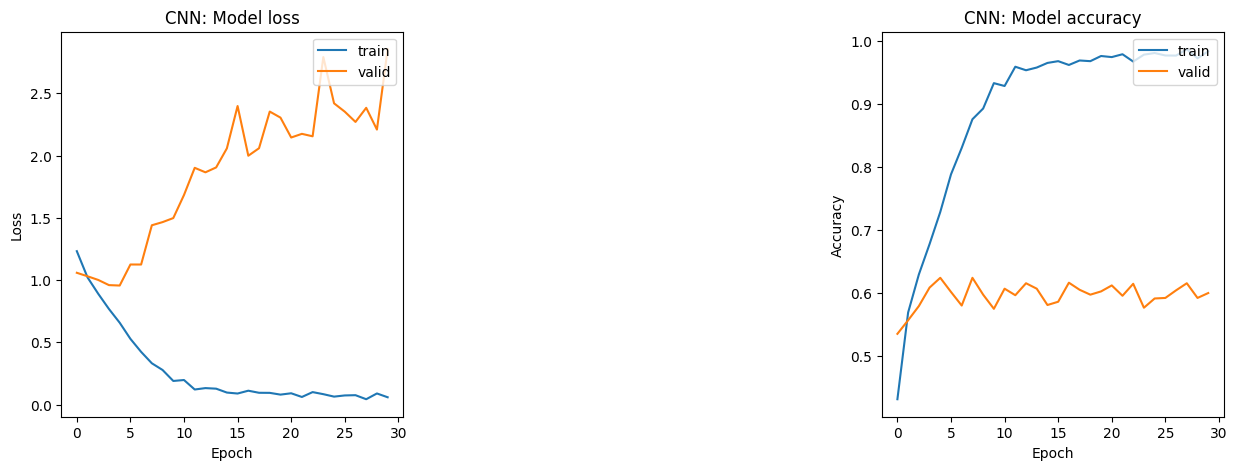

In [94]:
plot_helper.plot_history(history, "CNN")

Accuracy: 0.48985239852398527


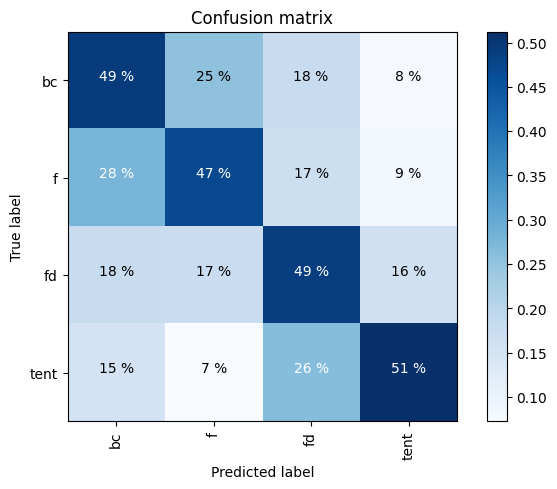

In [95]:
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, valid_mask_generator)

In [96]:
cnn_model.evaluate(test_mask_generator)

68/68 [==============================] - 1s 18ms/step - loss: 0.7235 - accuracy: 0.8764


[0.7234894633293152, 0.8763837814331055]

Accuracy: 0.8763837638376384


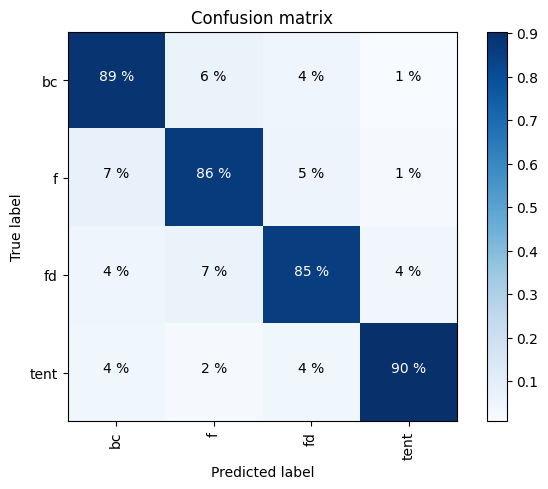

In [97]:
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, test_mask_generator)

## Compare the networks

Both networks have similar accuray, learning curve and cofusion matrix. But the network for the masked images trains faster.

# Part 2

## a) Choose a network that you think is better to proceed with, motivate why
    

We choose network with masked images.  Mask can highlight the specific area in the image, ignore other unrelated parts, fitting our tasks better.

## b) Try 3 different improvements of your network, motivate your choices


### Attempt 1

The easist way to think about is to add some more convolution layers and pooling layers to the model, try changing the filter sizes, and the number of filters as well.

In this modified model, we increased the depth of the convolutional layers and tried different sizes of convolutional kernels. The first convolutional layer used a 3x3 kernel size, the second convolutional layer used a 5x5 kernel size, and the third convolutional layer reverted to a 3x3 kernel size. Additionally, we increased the number of filters in each convolutional layer.

In [101]:
cnn_inputs = keras.Input(shape=(40, 40, 1))

x = layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(128, kernel_size=(5, 5), strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(256, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)

x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)

cnn_outputs = layers.Dense(4, activation='softmax')(x)

cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model_unmasked_images_attempt_1")
cnn_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()


Model: "cnn_Model_unmasked_images_attempt_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 40, 40, 1)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 40, 40, 64)        640       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 20, 20, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 20, 20, 128)       204928    
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 10, 10, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (N

In [102]:
epochs = 30
history_mask = cnn_model.fit(x=train_mask_generator,
                    steps_per_epoch= train_mask_steps,
                    validation_data= valid_mask_generator,
                    validation_steps= validation_mask_steps,
                    epochs= epochs
        )

Epoch 1/30
542/542 [==============================] - 20s 35ms/step - loss: 1.3025 - accuracy: 0.3713 - val_loss: 1.2958 - val_accuracy: 0.3852
Epoch 2/30
542/542 [==============================] - 14s 25ms/step - loss: 1.2438 - accuracy: 0.4207 - val_loss: 1.2341 - val_accuracy: 0.4222
Epoch 3/30
542/542 [==============================] - 14s 26ms/step - loss: 1.1710 - accuracy: 0.4666 - val_loss: 1.1611 - val_accuracy: 0.4769
Epoch 4/30
542/542 [==============================] - 13s 24ms/step - loss: 1.1329 - accuracy: 0.4950 - val_loss: 1.1221 - val_accuracy: 0.4722
Epoch 5/30
542/542 [==============================] - 13s 24ms/step - loss: 1.0996 - accuracy: 0.5223 - val_loss: 1.1625 - val_accuracy: 0.4769
Epoch 6/30
542/542 [==============================] - 11s 21ms/step - loss: 1.0609 - accuracy: 0.5426 - val_loss: 1.1184 - val_accuracy: 0.5019
Epoch 7/30
542/542 [==============================] - 10s 18ms/step - loss: 1.0234 - accuracy: 0.5548 - val_loss: 1.1587 - val_accuracy:

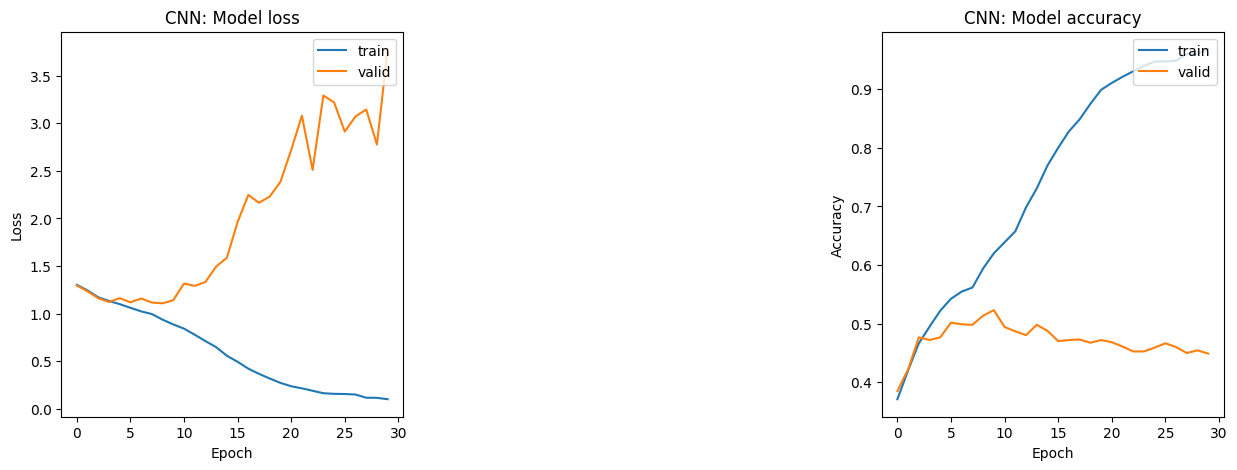

In [103]:
plot_helper.plot_history(history_mask, "CNN")

Accuracy: 0.45018450184501846


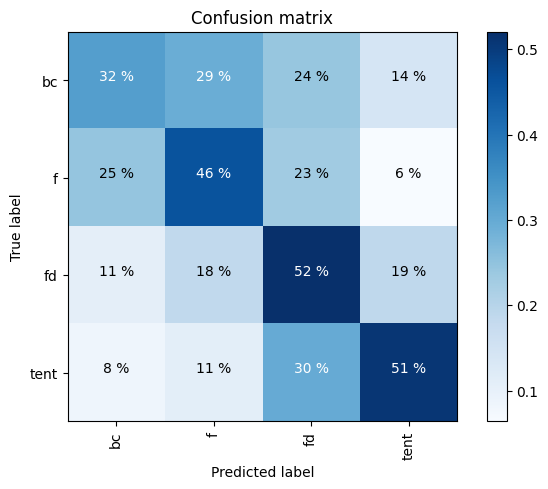

In [104]:
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, valid_mask_generator)

In [105]:
cnn_model.evaluate(test_mask_generator)

68/68 [==============================] - 1s 16ms/step - loss: 0.8984 - accuracy: 0.8838


[0.8983597755432129, 0.88376384973526]

Accuracy: 0.8837638376383764


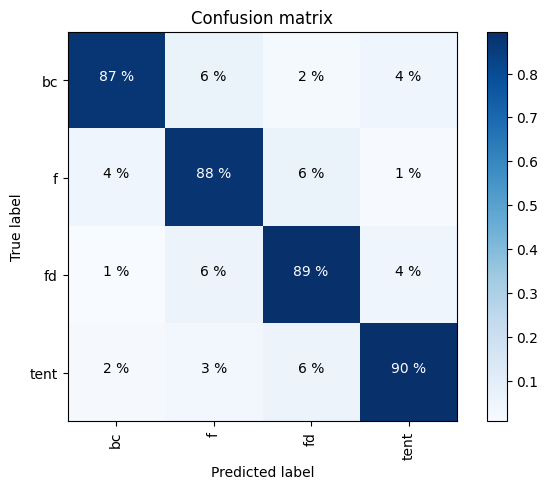

In [106]:
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, test_mask_generator)

### Attempt 2

The first attempt dosen't change too much about accuarcy. In attempt 2, we try data augmentation.

In [132]:
train_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./65535,
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./65535,
    samplewise_center=True,
    samplewise_std_normalization=True
)

test_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./65535,
    samplewise_center=True,
    samplewise_std_normalization=True
)

train_mask_generator = train_data_generator.flow_from_dataframe(
    df_mask_train, 
    directory=masks_cell_path, 
    x_col=filename_column, 
    y_col=true_label_column,
    weight_col=None, 
    class_mode='categorical', 
    batch_size=batch_size, 
    target_size=image_shape,  
    color_mode='grayscale', 
    shuffle=True
)

valid_mask_generator = valid_data_generator.flow_from_dataframe(
    df_mask_validation, 
    directory=masks_cell_path, 
    x_col=filename_column, 
    y_col=true_label_column,
    weight_col=None, 
    class_mode='categorical', 
    batch_size=batch_size, 
    target_size=image_shape,  
    color_mode='grayscale', 
    shuffle=False
)

test_mask_generator = test_data_generator.flow_from_dataframe(
    df_mask_test, 
    directory=masks_cell_path, 
    x_col=filename_column, 
    y_col=true_label_column,
    weight_col=None, 
    class_mode='categorical', 
    batch_size=batch_size, 
    target_size=image_shape,  
    color_mode='grayscale', 
    shuffle=False
)

train_mask_steps = train_mask_generator.n//train_mask_generator.batch_size if train_mask_generator.n >= train_mask_generator.batch_size else 1
validation_mask_steps = valid_mask_generator.n//valid_mask_generator.batch_size if valid_mask_generator.n >= valid_mask_generator.batch_size else 1


Found 4339 validated image filenames belonging to 4 classes.
Found 1084 validated image filenames belonging to 4 classes.
Found 542 validated image filenames belonging to 4 classes.


In [133]:
cnn_inputs = keras.Input(shape=(40, 40, 1))  # Input tensor shape (32, 32, 1)

x = layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding='same')(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(128, kernel_size=(3, 3), strides=1, padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)

cnn_outputs = layers.Dense(4, activation='softmax')(x)  # Output layer

cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model_masked_images_attempt_2")
cnn_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "cnn_Model_masked_images_attempt_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 40, 40, 1)]       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 40, 40, 32)        320       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 20, 20, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (Non

In [134]:
epochs = 30
history_mask = cnn_model.fit(x=train_mask_generator,
                    steps_per_epoch= train_mask_steps,
                    validation_data= valid_mask_generator,
                    validation_steps= validation_mask_steps,
                    epochs= epochs
        )

Epoch 1/30
542/542 [==============================] - 19s 33ms/step - loss: 1.3657 - accuracy: 0.3025 - val_loss: 1.3905 - val_accuracy: 0.3222
Epoch 2/30
542/542 [==============================] - 13s 25ms/step - loss: 1.3068 - accuracy: 0.3676 - val_loss: 1.4004 - val_accuracy: 0.2852
Epoch 3/30
542/542 [==============================] - 13s 25ms/step - loss: 1.2863 - accuracy: 0.3791 - val_loss: 1.2908 - val_accuracy: 0.4037
Epoch 4/30
542/542 [==============================] - 13s 24ms/step - loss: 1.2750 - accuracy: 0.3930 - val_loss: 1.2191 - val_accuracy: 0.4481
Epoch 5/30
542/542 [==============================] - 12s 22ms/step - loss: 1.2571 - accuracy: 0.4052 - val_loss: 1.2538 - val_accuracy: 0.3741
Epoch 6/30
542/542 [==============================] - 16s 29ms/step - loss: 1.2594 - accuracy: 0.4133 - val_loss: 1.3683 - val_accuracy: 0.3352
Epoch 7/30
542/542 [==============================] - 13s 24ms/step - loss: 1.2412 - accuracy: 0.4198 - val_loss: 1.2423 - val_accuracy:

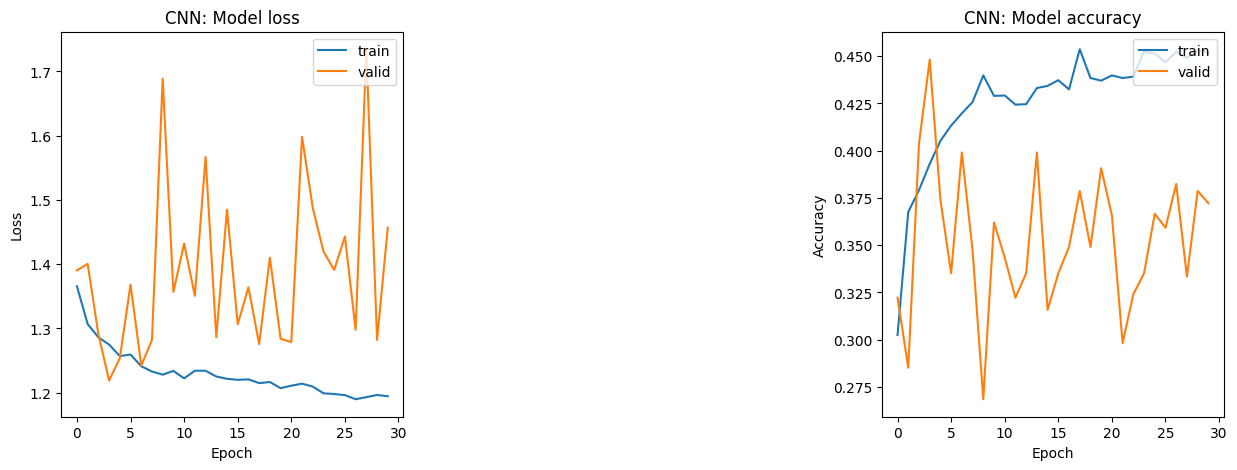

In [135]:
plot_helper.plot_history(history_mask, "CNN")

Accuracy: 0.37177121771217714


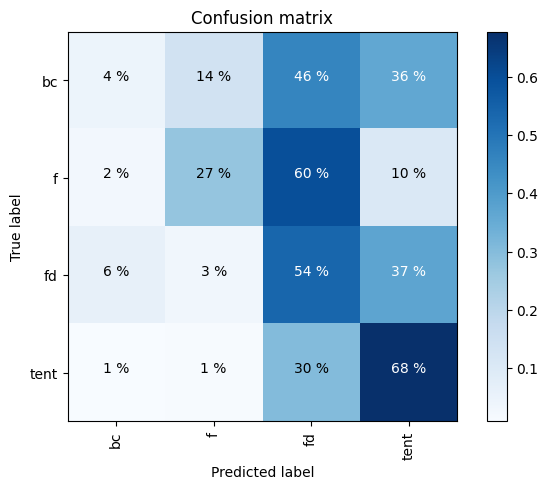

In [136]:
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, valid_mask_generator)

In [137]:
cnn_model.evaluate(test_mask_generator)

68/68 [==============================] - 1s 19ms/step - loss: 1.3973 - accuracy: 0.3985


[1.3972692489624023, 0.3985239863395691]

Accuracy: 0.3985239852398524


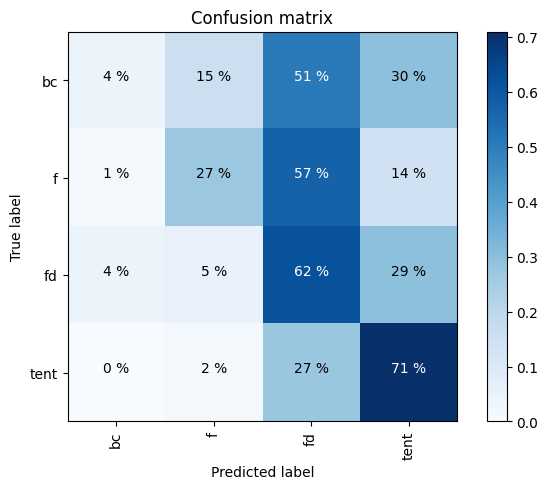

In [138]:
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, test_mask_generator)

### Attempt 3

Attempt 2 doesn't improve the performance. Attempt 3 we add both BatchNormalization and DropOut. 

In [114]:
df_mask_labels = pd.read_csv('/home/jovyan/big-data_deeplearning/re_assignments/masked_cell_labels.csv')
df_mask_labels.head()
df_mask_labels.shape
true_label_column = "class"
df_mask_labels[true_label_column].unique()
df_mask_labels[true_label_column].value_counts()
class_column_header = "class"
df_mask_labels_to_use = df_mask_labels.copy() 
test_set_fraction = 0.1
validation_set_fraction = 0.2
df_mask_test = df_mask_labels_to_use.groupby(class_column_header).sample(frac = test_set_fraction)
df_mask_to_use = pd.concat([df_mask_labels_to_use, df_mask_test, df_mask_test]).drop_duplicates(keep=False) 
df_mask_validation = df_mask_labels_to_use.groupby(class_column_header).sample(frac = validation_set_fraction)
df_mask_train = pd.concat([df_mask_labels_to_use, df_mask_validation, df_mask_validation]).drop_duplicates(keep=False)
print(df_mask_test.head())

                   filename  type class unknown1  unknown2  unknown3  \
2072  cell_bc_s1_2__370.tif  cell    bc       s1         2       NaN   
2085  cell_bc_s1_1__264.tif  cell    bc       s1         1       NaN   
4373  cell_bc_s1_2__522.tif  cell    bc       s1         2       NaN   
2815  cell_bc_s1_1__824.tif  cell    bc       s1         1       NaN   
4673  cell_bc_s1_1__171.tif  cell    bc       s1         1       NaN   

     original_image_name  
2072             370.tif  
2085             264.tif  
4373             522.tif  
2815             824.tif  
4673             171.tif  


In [115]:
batch_size = 8
masks_cell_path ='/home/jovyan/big-data_deeplearning/re_assignments/masked_cells/'
image_shape = (40,40)
filename_column = 'filename'
true_label_column = "class"

train_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./65535, samplewise_center=True, samplewise_std_normalization=True)
valid_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./65535, samplewise_center=True, samplewise_std_normalization=True)
test_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./65535, samplewise_center=True, samplewise_std_normalization=True)

train_mask_generator = train_data_generator.flow_from_dataframe(
    df_mask_train, directory=masks_cell_path, x_col=filename_column, y_col=true_label_column,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' ,shuffle=True,
)

valid_mask_generator = valid_data_generator.flow_from_dataframe(
    df_mask_validation, directory=masks_cell_path, x_col=filename_column, y_col=true_label_column,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' ,shuffle=False,
)


test_mask_generator = test_data_generator.flow_from_dataframe(
    df_mask_test, directory=masks_cell_path, x_col=filename_column, y_col=true_label_column,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' ,shuffle=False,
)

train_mask_steps = train_mask_generator.n//train_mask_generator.batch_size if train_mask_generator.n >= train_mask_generator.batch_size else 1
validation_mask_steps = valid_mask_generator.n//valid_mask_generator.batch_size if valid_mask_generator.n >= valid_mask_generator.batch_size else 1

Found 4339 validated image filenames belonging to 4 classes.
Found 1084 validated image filenames belonging to 4 classes.
Found 542 validated image filenames belonging to 4 classes.


In [116]:
from tensorflow.keras import layers, models

cnn_inputs = keras.Input(shape=(40, 40, 1))

x = layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(cnn_inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(64, kernel_size=(5, 5), strides=1, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(128, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)

cnn_outputs = layers.Dense(4, activation='softmax')(x)

cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model_with_BN_and_Dropout")
cnn_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "cnn_Model_with_BN_and_Dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 40, 40, 1)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 40, 40, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 40, 40, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 20, 20, 32)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 20, 20, 32)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 2

In [117]:
epochs = 30
history_mask = cnn_model.fit(x=train_mask_generator,
                    steps_per_epoch= train_mask_steps,
                    validation_data= valid_mask_generator,
                    validation_steps= validation_mask_steps,
                    epochs= epochs
        )

Epoch 1/30
542/542 [==============================] - 22s 35ms/step - loss: 1.5135 - accuracy: 0.3369 - val_loss: 1.3492 - val_accuracy: 0.4037
Epoch 2/30
542/542 [==============================] - 14s 26ms/step - loss: 1.3525 - accuracy: 0.3639 - val_loss: 1.2713 - val_accuracy: 0.4065
Epoch 3/30
542/542 [==============================] - 15s 27ms/step - loss: 1.3080 - accuracy: 0.3757 - val_loss: 1.2940 - val_accuracy: 0.3824
Epoch 4/30
542/542 [==============================] - 14s 26ms/step - loss: 1.2582 - accuracy: 0.4184 - val_loss: 1.2523 - val_accuracy: 0.4352
Epoch 5/30
542/542 [==============================] - 14s 25ms/step - loss: 1.2305 - accuracy: 0.4278 - val_loss: 1.1625 - val_accuracy: 0.4889
Epoch 6/30
542/542 [==============================] - 14s 25ms/step - loss: 1.2183 - accuracy: 0.4417 - val_loss: 1.2467 - val_accuracy: 0.4231
Epoch 7/30
542/542 [==============================] - 14s 26ms/step - loss: 1.2128 - accuracy: 0.4530 - val_loss: 1.2967 - val_accuracy:

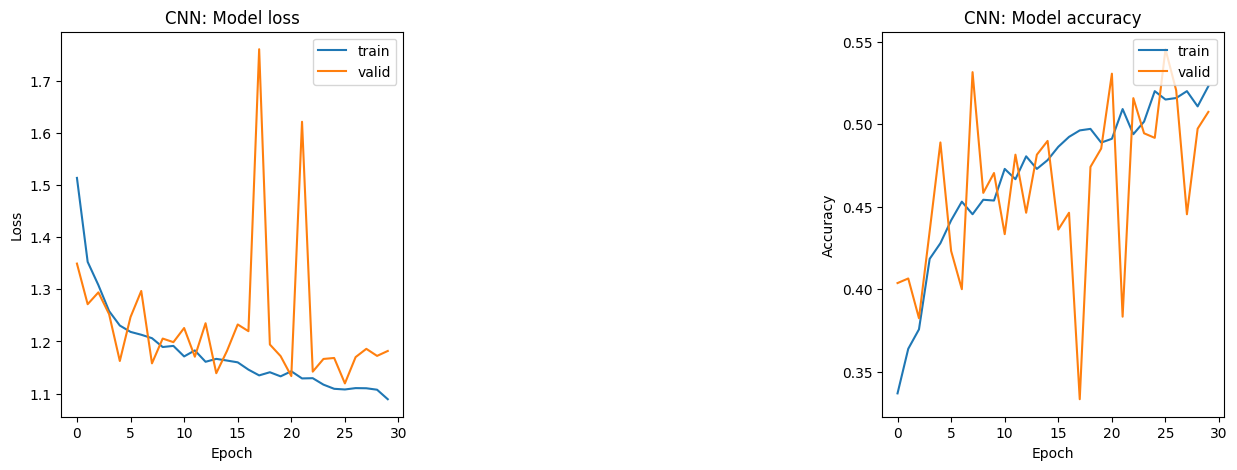

In [118]:
plot_helper.plot_history(history_mask, "CNN")

Accuracy: 0.507380073800738


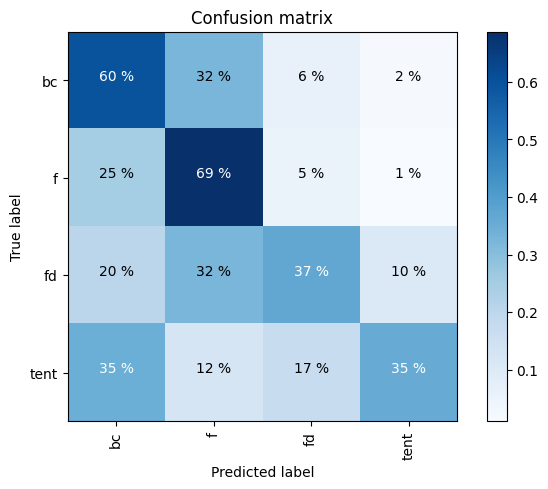

In [119]:
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, valid_mask_generator)

In [120]:
cnn_model.evaluate(test_mask_generator)

68/68 [==============================] - 1s 16ms/step - loss: 1.0418 - accuracy: 0.5498


[1.0418243408203125, 0.5498154759407043]

Accuracy: 0.5498154981549815


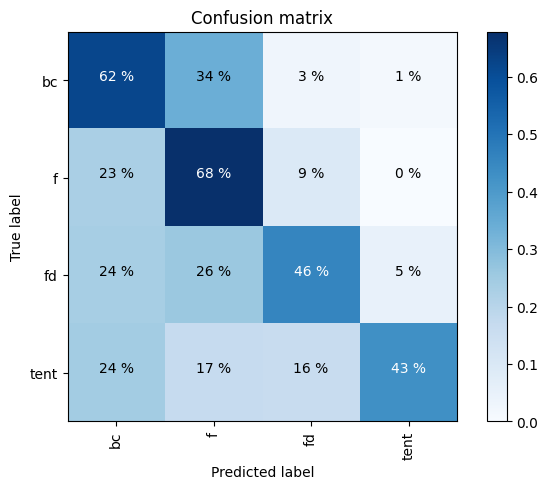

In [121]:
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, test_mask_generator)

## c) Combine your 3 improvements, discuss the results

### Attempt 4

In [139]:
df_mask_labels = pd.read_csv('/home/jovyan/big-data_deeplearning/re_assignments/masked_cell_labels.csv')
df_mask_labels.head()
df_mask_labels.shape
true_label_column = "class"
df_mask_labels[true_label_column].unique()
df_mask_labels[true_label_column].value_counts()
class_column_header = "class"
df_mask_labels_to_use = df_mask_labels.copy() 
test_set_fraction = 0.1
validation_set_fraction = 0.2
df_mask_test = df_mask_labels_to_use.groupby(class_column_header).sample(frac = test_set_fraction)
df_mask_to_use = pd.concat([df_mask_labels_to_use, df_mask_test, df_mask_test]).drop_duplicates(keep=False) 
df_mask_validation = df_mask_labels_to_use.groupby(class_column_header).sample(frac = validation_set_fraction)
df_mask_train = pd.concat([df_mask_labels_to_use, df_mask_validation, df_mask_validation]).drop_duplicates(keep=False)
print(df_mask_test.head())

                   filename  type class unknown1  unknown2  unknown3  \
816   cell_bc_s1_2__293.tif  cell    bc       s1         2       NaN   
4687  cell_bc_s1_1__629.tif  cell    bc       s1         1       NaN   
2371  cell_bc_s1_1__735.tif  cell    bc       s1         1       NaN   
4541  cell_bc_s1_1__764.tif  cell    bc       s1         1       NaN   
3171  cell_bc_s1_2__258.tif  cell    bc       s1         2       NaN   

     original_image_name  
816              293.tif  
4687             629.tif  
2371             735.tif  
4541             764.tif  
3171             258.tif  


In [140]:
train_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./65535,
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./65535,
    samplewise_center=True,
    samplewise_std_normalization=True
)

test_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./65535,
    samplewise_center=True,
    samplewise_std_normalization=True
)

train_mask_generator = train_data_generator.flow_from_dataframe(
    df_mask_train, 
    directory=masks_cell_path, 
    x_col=filename_column, 
    y_col=true_label_column,
    weight_col=None, 
    class_mode='categorical', 
    batch_size=batch_size, 
    target_size=image_shape,  
    color_mode='grayscale', 
    shuffle=True
)

valid_mask_generator = valid_data_generator.flow_from_dataframe(
    df_mask_validation, 
    directory=masks_cell_path, 
    x_col=filename_column, 
    y_col=true_label_column,
    weight_col=None, 
    class_mode='categorical', 
    batch_size=batch_size, 
    target_size=image_shape,  
    color_mode='grayscale', 
    shuffle=False
)

test_mask_generator = test_data_generator.flow_from_dataframe(
    df_mask_test, 
    directory=masks_cell_path, 
    x_col=filename_column, 
    y_col=true_label_column,
    weight_col=None, 
    class_mode='categorical', 
    batch_size=batch_size, 
    target_size=image_shape,  
    color_mode='grayscale', 
    shuffle=False
)

train_mask_steps = train_mask_generator.n//train_mask_generator.batch_size if train_mask_generator.n >= train_mask_generator.batch_size else 1
validation_mask_steps = valid_mask_generator.n//valid_mask_generator.batch_size if valid_mask_generator.n >= valid_mask_generator.batch_size else 1

Found 4339 validated image filenames belonging to 4 classes.
Found 1084 validated image filenames belonging to 4 classes.
Found 542 validated image filenames belonging to 4 classes.


In [141]:
from tensorflow.keras import layers, models

cnn_inputs = keras.Input(shape=(40, 40, 1))

x = layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(cnn_inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(64, kernel_size=(5, 5), strides=1, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(128, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)

cnn_outputs = layers.Dense(4, activation='softmax')(x)

cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model_with_BN_and_Dropout")
cnn_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()


Model: "cnn_Model_with_BN_and_Dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 40, 40, 1)]       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 40, 40, 32)        320       
                                                                 
 batch_normalization_12 (Bat  (None, 40, 40, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 20, 20, 32)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 20, 20, 32)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 2

In [142]:
epochs = 30
history_mask = cnn_model.fit(x=train_mask_generator,
                    steps_per_epoch= train_mask_steps,
                    validation_data= valid_mask_generator,
                    validation_steps= validation_mask_steps,
                    epochs= epochs
        )

Epoch 1/30
542/542 [==============================] - 26s 38ms/step - loss: 1.5858 - accuracy: 0.2905 - val_loss: 1.4464 - val_accuracy: 0.3065
Epoch 2/30
542/542 [==============================] - 14s 26ms/step - loss: 1.3952 - accuracy: 0.3256 - val_loss: 1.3279 - val_accuracy: 0.3769
Epoch 3/30
542/542 [==============================] - 13s 25ms/step - loss: 1.3509 - accuracy: 0.3396 - val_loss: 1.3024 - val_accuracy: 0.3880
Epoch 4/30
542/542 [==============================] - 14s 25ms/step - loss: 1.3323 - accuracy: 0.3514 - val_loss: 1.4557 - val_accuracy: 0.3157
Epoch 5/30
542/542 [==============================] - 16s 29ms/step - loss: 1.3118 - accuracy: 0.3639 - val_loss: 1.6016 - val_accuracy: 0.2926
Epoch 6/30
542/542 [==============================] - 12s 22ms/step - loss: 1.3087 - accuracy: 0.3676 - val_loss: 1.4788 - val_accuracy: 0.3556
Epoch 7/30
542/542 [==============================] - 14s 26ms/step - loss: 1.2852 - accuracy: 0.3934 - val_loss: 1.3952 - val_accuracy:

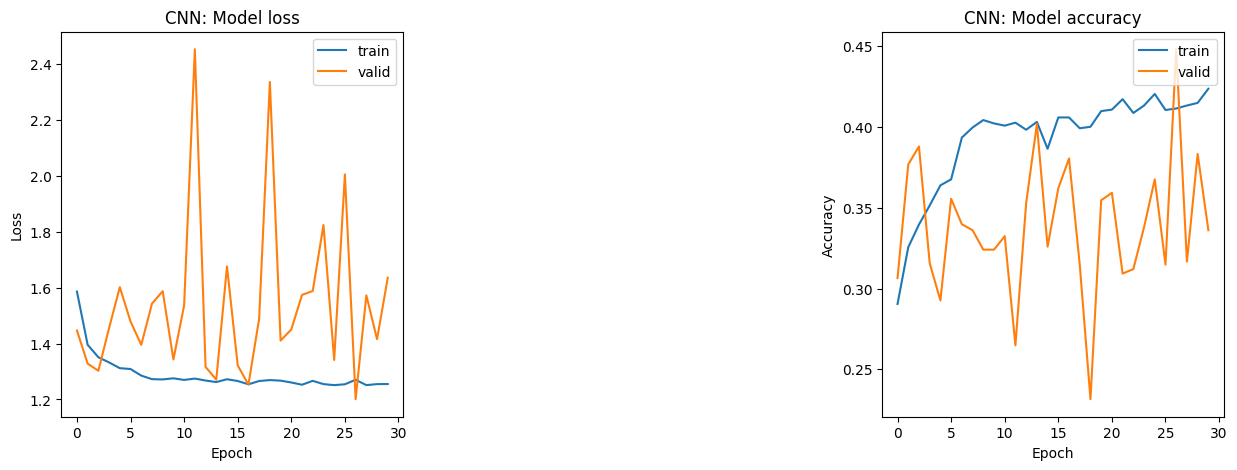

In [143]:
plot_helper.plot_history(history_mask, "CNN")

Accuracy: 0.3376383763837638


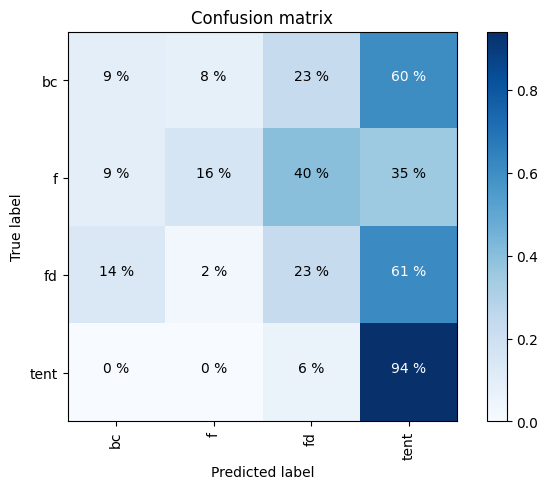

In [144]:
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, valid_mask_generator)

In [145]:
cnn_model.evaluate(test_mask_generator)

68/68 [==============================] - 1s 16ms/step - loss: 1.5696 - accuracy: 0.3524


[1.5696048736572266, 0.35239851474761963]

Accuracy: 0.35239852398523985


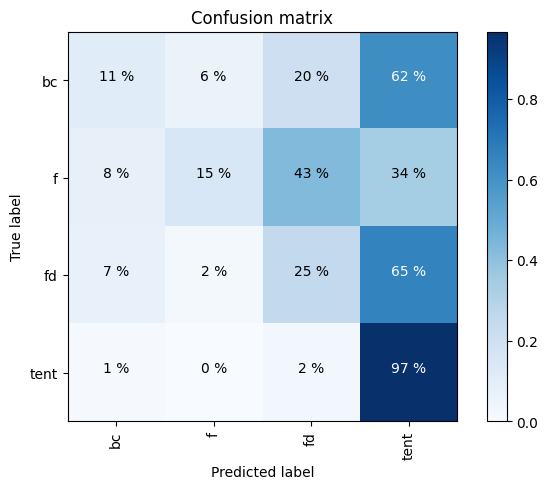

In [146]:
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, test_mask_generator)

Combining three attempts, attempt 4 doee not perform better. It may be influenced by attempt 2 and attempt 3, because their performance is negatively optimized.

# Part 3
A badly performing network run atleast once. Motivate why you chose this network (1 paragraph). 

In [153]:
#The worst model performing network


train_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./65535,
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./65535,
    samplewise_center=True,
    samplewise_std_normalization=True
)

test_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./65535,
    samplewise_center=True,
    samplewise_std_normalization=True
)

train_mask_generator = train_data_generator.flow_from_dataframe(
    df_mask_train, 
    directory=masks_cell_path, 
    x_col=filename_column, 
    y_col=true_label_column,
    weight_col=None, 
    class_mode='categorical', 
    batch_size=batch_size, 
    target_size=image_shape,  
    color_mode='grayscale', 
    shuffle=True
)

valid_mask_generator = valid_data_generator.flow_from_dataframe(
    df_mask_validation, 
    directory=masks_cell_path, 
    x_col=filename_column, 
    y_col=true_label_column,
    weight_col=None, 
    class_mode='categorical', 
    batch_size=batch_size, 
    target_size=image_shape,  
    color_mode='grayscale', 
    shuffle=False
)

test_mask_generator = test_data_generator.flow_from_dataframe(
    df_mask_test, 
    directory=masks_cell_path, 
    x_col=filename_column, 
    y_col=true_label_column,
    weight_col=None, 
    class_mode='categorical', 
    batch_size=batch_size, 
    target_size=image_shape,  
    color_mode='grayscale', 
    shuffle=False
)

train_mask_steps = train_mask_generator.n//train_mask_generator.batch_size if train_mask_generator.n >= train_mask_generator.batch_size else 1
validation_mask_steps = valid_mask_generator.n//valid_mask_generator.batch_size if valid_mask_generator.n >= valid_mask_generator.batch_size else 1


Found 4339 validated image filenames belonging to 4 classes.
Found 1084 validated image filenames belonging to 4 classes.
Found 542 validated image filenames belonging to 4 classes.


In [154]:
cnn_inputs = keras.Input(shape=(40, 40, 1))  # Input tensor shape (32, 32, 1)

x = layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding='same')(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(128, kernel_size=(3, 3), strides=1, padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)

cnn_outputs = layers.Dense(4, activation='softmax')(x)  # Output layer

cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model_masked_images_attempt_2")
cnn_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "cnn_Model_masked_images_attempt_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 40, 40, 1)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 40, 40, 32)        320       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 20, 20, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (Non

In [155]:
epochs = 30
history_mask = cnn_model.fit(x=train_mask_generator,
                    steps_per_epoch= train_mask_steps,
                    validation_data= valid_mask_generator,
                    validation_steps= validation_mask_steps,
                    epochs= epochs
        )

Epoch 1/30
542/542 [==============================] - 23s 40ms/step - loss: 1.3571 - accuracy: 0.3129 - val_loss: 1.4523 - val_accuracy: 0.3019
Epoch 2/30
542/542 [==============================] - 15s 27ms/step - loss: 1.3114 - accuracy: 0.3641 - val_loss: 1.2805 - val_accuracy: 0.3398
Epoch 3/30
542/542 [==============================] - 10s 19ms/step - loss: 1.2839 - accuracy: 0.3817 - val_loss: 1.4426 - val_accuracy: 0.2917
Epoch 4/30
542/542 [==============================] - 13s 24ms/step - loss: 1.2607 - accuracy: 0.4027 - val_loss: 1.4500 - val_accuracy: 0.3065
Epoch 5/30
542/542 [==============================] - 14s 26ms/step - loss: 1.2555 - accuracy: 0.4008 - val_loss: 1.3609 - val_accuracy: 0.3593
Epoch 6/30
542/542 [==============================] - 14s 25ms/step - loss: 1.2510 - accuracy: 0.4147 - val_loss: 1.4325 - val_accuracy: 0.2843
Epoch 7/30
542/542 [==============================] - 12s 21ms/step - loss: 1.2445 - accuracy: 0.4205 - val_loss: 1.4525 - val_accuracy:

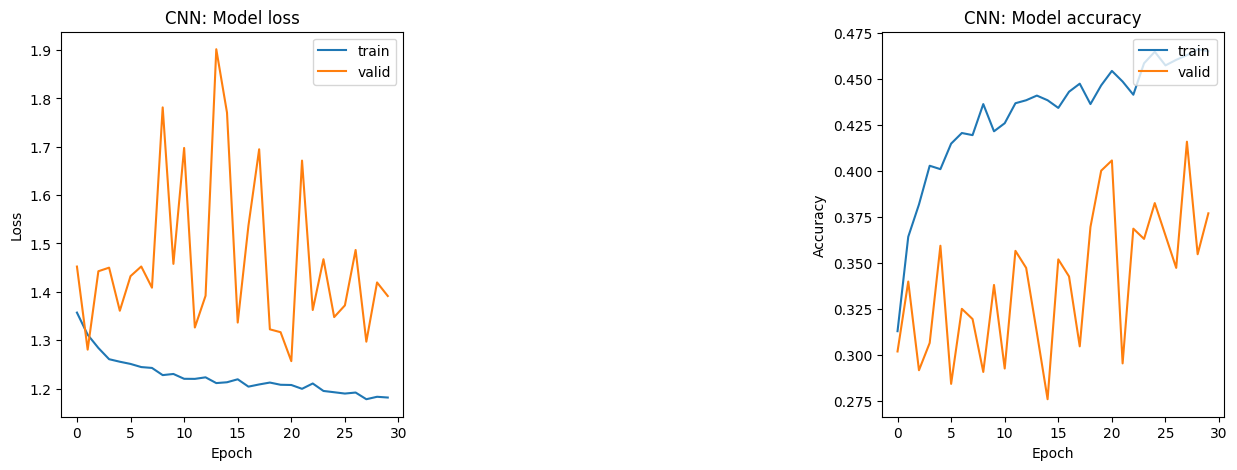

In [156]:
plot_helper.plot_history(history_mask, "CNN")

Accuracy: 0.3763837638376384


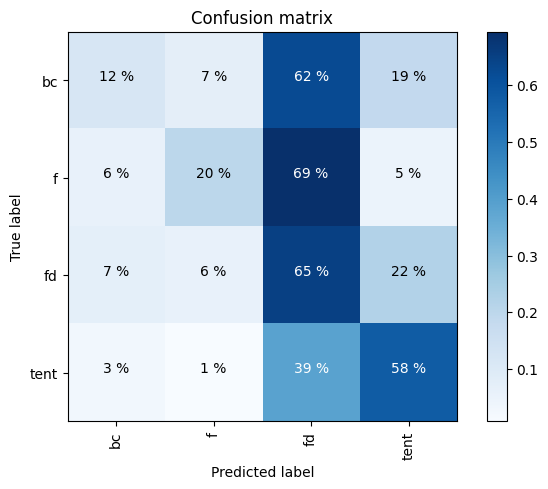

In [157]:
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, valid_mask_generator)

In [158]:
cnn_model.evaluate(test_mask_generator)

68/68 [==============================] - 1s 14ms/step - loss: 1.3302 - accuracy: 0.3948


[1.3302390575408936, 0.3948339521884918]

Accuracy: 0.3948339483394834


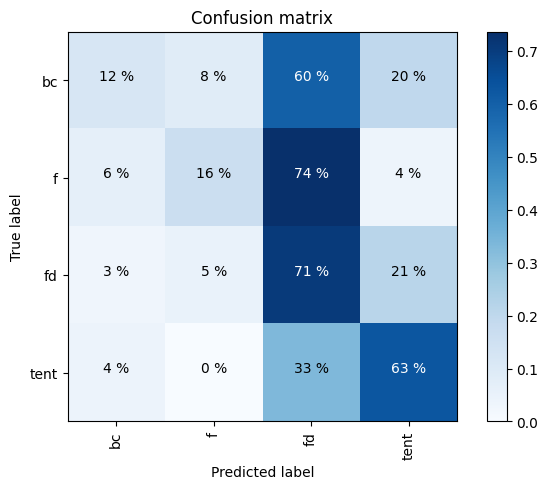

In [159]:
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, test_mask_generator)

In [ ]:
'''
Badly performed network: model 2

Possible reason for bad performance: 

1. fewer filter: The second model uses fewer filters in the convolutional layers compared to the first model. 
This reduces the model's capacity to learn and extract complex features from the input images.

2. Smaller kernel size:  The second model uses a consistent 3x3 kernel size for all convolutional layers, whereas the first model uses a larger 5x5 kernel in the second convolutional block. 
Larger kernels can capture more spatial information.

3. Fewer units in dense layer: The second model has fewer units in the dense layers, which limits its ability to learn complex representations and combine feature efficiently.

'''

# Part 4

In [136]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score


def evaluate_model(model, test_generator):
    test_steps = test_generator.n // test_generator.batch_size
    test_generator.reset()
    predictions = model.predict(test_generator, steps=test_steps, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes[:len(y_pred)]  # Ensure the true labels align with the predictions
    

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    return accuracy, precision, recall



accuracy, precision, recall = evaluate_model(cnn_model, test_generator)
print("First Model (Unmasked Images) - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(accuracy, precision, recall))


72/72 [==============================] - 1s 6ms/step
First Model (Unmasked Images) - Accuracy: 0.8767, Precision: 0.8790, Recall: 0.8767


In [ ]:
'''
An accuracy of 0.8767 indicates that the model is correct 87.67% of the time across all predictions. This is a good overall performance metric, showing that the model makes accurate predictions most of the time. 
A precision of 0.8790 means that when the model predicts a positive class, it is correct 87.90% of the time. This high precision indicates that the model has a low false positive rate, meaning it does not often incorrectly predict positive when it should not. 
A recall of 0.8767 means that the model correctly identifies 87.67% of the actual positive cases. This high recall indicates that the model has a low false negative rate, meaning it successfully identifies most of the actual positive cases.

Both accuracy (0.8767) and precision (0.8790) are very close in value, suggesting that the model not only performs well overall but also makes very accurate positive predictions. This similarity indicates a balanced performance where the model correctly predicts both positive and negative cases with high reliability. 
Accuracy (0.8767) and recall (0.8767) are identical, indicating that the model's overall correctness is equally matched by its ability to identify all positive cases. This balance shows that the model is not biased towards either false positives or false negatives, providing a consistent performance. 
Precision (0.8790) and recall (0.8767) are almost identical, showing that the model is well-tuned to make positive predictions with minimal error. The slight difference suggests that the model is marginally better at avoiding false positives compared to identifying all true positives, but the difference is negligible.

'''

Evaluate your best network using atleast 3 metrics and discuss their differences/similarities in relation to your results.  (1-3 paragraphs)